In [7]:
import pandas as pd 

train = pd.read_csv("../data/train.csv", parse_dates=["date"])

train.head()



,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
# Pick a store and Family
focus_store  = 1            
focus_family = "GROCERY I"

df = train[(train["store_nbr"] == focus_store) &
           (train["family"]    == focus_family)].copy()

print(df.shape)    
df.head()          


(1684, 6)


,id,date,store_nbr,family,sales,onpromotion
12,12,2013-01-01,1,GROCERY I,0.0,0
1794,1794,2013-01-02,1,GROCERY I,2652.0,0
3576,3576,2013-01-03,1,GROCERY I,2121.0,0
5358,5358,2013-01-04,1,GROCERY I,2056.0,0
7140,7140,2013-01-05,1,GROCERY I,2216.0,0


Turn Daily Sales into Monthly Totals

In [9]:

monthly = (df
           .set_index("date")         # make 'date' the index
           .resample("ME")             # "ME" = month-end frequency
           .agg({"sales": "sum"})     # sum daily sales inside each month
           .reset_index())

print(monthly.head())
print(monthly.tail())
print(monthly.shape)

        date    sales
0 2013-01-31  53397.0
1 2013-02-28  45447.0
2 2013-03-31  52736.0
3 2013-04-30  54654.0
4 2013-05-31  55290.0
         date    sales
51 2017-04-30  75612.0
52 2017-05-31  79351.0
53 2017-06-30  84136.0
54 2017-07-31  77898.0
55 2017-08-31  33823.0
(56, 2)


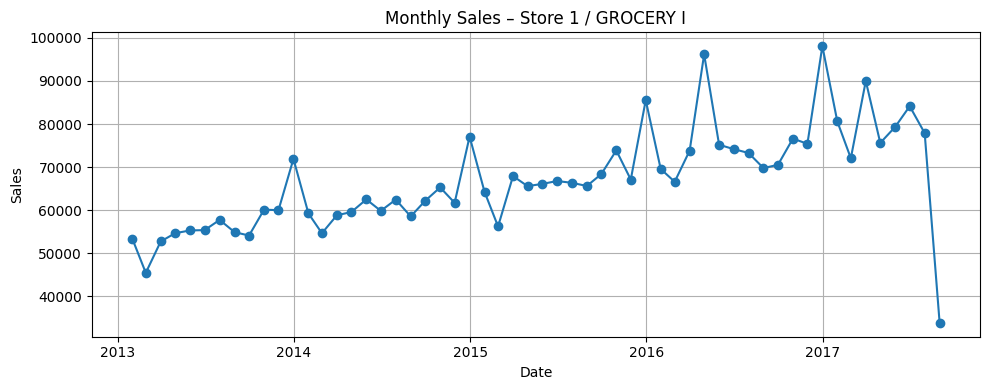

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(monthly["date"], monthly["sales"], marker="o")
plt.title(f"Monthly Sales – Store {focus_store} / {focus_family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

STEP 2: Prepare the Data for Prophet

In [12]:
df_prophet = monthly.rename(columns={"date": "ds", "sales": "y"})
df_prophet.head()

,ds,y
0,2013-01-31,53397.0
1,2013-02-28,45447.0
2,2013-03-31,52736.0
3,2013-04-30,54654.0
4,2013-05-31,55290.0
